In [2]:
%matplotlib inline
from rtxlib.rtx_run import setup_database, db
from analysis_lib.one_sample_tests import KolmogorovSmirnov
from analysis_lib.two_sample_tests import Ttest

index = "rtx2"
setup_database(index)
results = db().get_all_data_points()

res = {}
data = {}
knobs = {}
for i in range(9):
    no = float("0."+str(i))
    res = [r for r in results if r[1]["route_random_sigma"]==no]
    data[i] = [r[0] for r in res]
    knobs[i] = [r[1] for r in res]
    print "0."+str(i)+"'s: " + str(len(data[i]))

print "end."

> OEDA configuration: Using elasticsearch database.
0.0's: 30000
0.1's: 0
0.2's: 30000
0.3's: 0
0.4's: 30000
0.5's: 0
0.6's: 30000
0.7's: 0
0.8's: 0
end.


[{u'tick': 23853, u'overhead': 1.1327109780844247}, {u'tick': 1423364, u'overhead': 0.9769314016845179}, {u'tick': 23854, u'overhead': 1.8720666639545687}, {u'tick': 23854, u'overhead': 2.7926512839121407}, {u'tick': 1423366, u'overhead': 0.29730100569303813}, {u'tick': 23855, u'overhead': 3.3831605403136846}, {u'tick': 23857, u'overhead': 1.9354835459386404}, {u'tick': 1423368, u'overhead': 0.37301873448910716}, {u'tick': 23859, u'overhead': 1.4413337422670969}, {u'tick': 23859, u'overhead': 2.5798392759030278}]
[{u'route_random_sigma': 0}, {u'route_random_sigma': 0}, {u'route_random_sigma': 0}, {u'route_random_sigma': 0}, {u'route_random_sigma': 0}, {u'route_random_sigma': 0}, {u'route_random_sigma': 0}, {u'route_random_sigma': 0}, {u'route_random_sigma': 0}, {u'route_random_sigma': 0}]


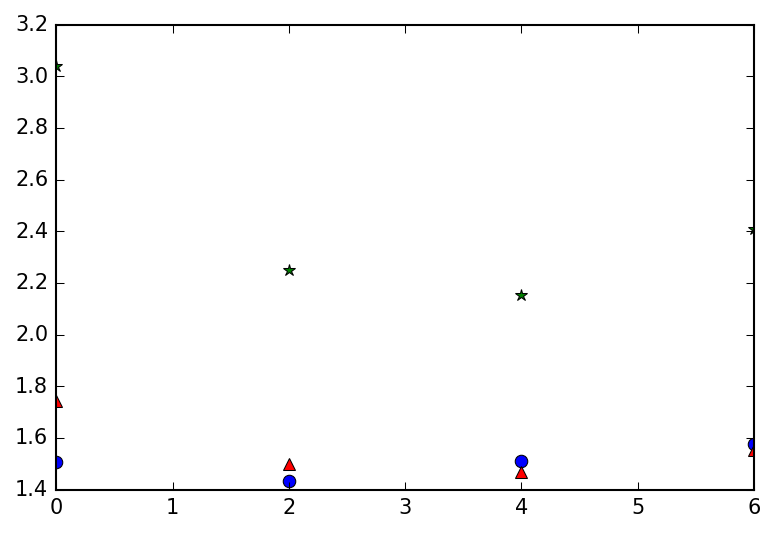

In [3]:
import matplotlib.pyplot as plt
from numpy import var, std
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

y_key = 'overhead'
threshold = 30000
alpha = 0.05
keys = [0, 2, 4, 6]
#keys = [0, 1, 2, 3, 4, 5, 6, 8]

averages = []
variances = []
standard_deviations = []

print data[0][:10]
print knobs[0][:10]
# plt.plot(data[0])
# plt.show()
# print knobs[0][:3]

for i in keys:
    analysis_data = [r[y_key] for r in data[i]][:threshold]
    avg = sum(analysis_data) / float(len(analysis_data))
    averages.append(avg)
    variances.append(var(analysis_data))
    standard_deviations.append(std(analysis_data))
        
fig,ax = plt.subplots()
ax.plot(keys,averages, "o", label='averages')
ax.plot(keys,variances,"*", label='variances')
ax.plot(keys,standard_deviations,"^", label='standard_deviations')
 
# plt.legend(loc='best')
plt.show()

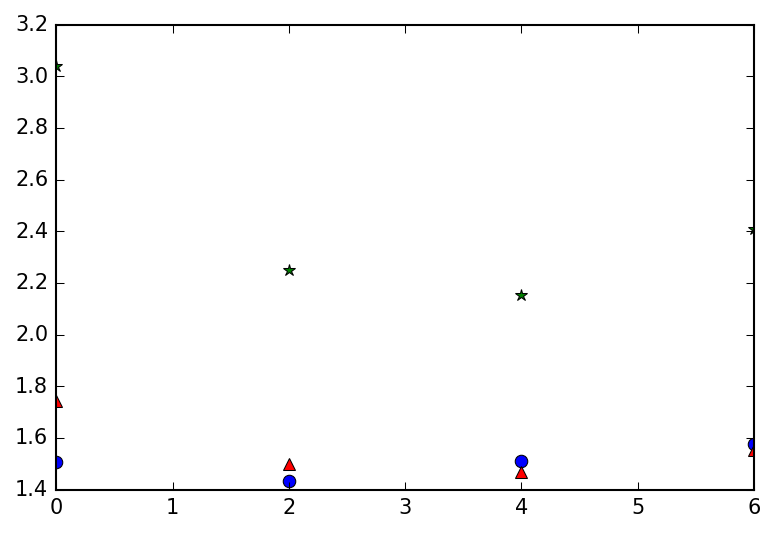

In [4]:
y_key = 'overhead'
threshold = 30000
alpha = 0.05
keys = [0, 2, 4, 6]

averages = []
variances = []
standard_deviations = []

for i in keys:
    analysis_data = [r[y_key] for r in data[i]][:threshold]
    avg = sum(analysis_data) / float(len(analysis_data))
    averages.append(avg)
    variances.append(var(analysis_data))
    standard_deviations.append(std(analysis_data))
        
fig,ax = plt.subplots()
ax.plot(keys,averages, "o", label='averages')
ax.plot(keys,variances,"*", label='variances')
ax.plot(keys,standard_deviations,"^", label='standard_deviations')
 
# plt.legend(loc='best')
plt.show()

In [6]:
alpha = 0.05
y_key = "overhead"
fake_run_id = "123456"
keys = [2, 4, 6]
# keys = [1, 2, 3, 4, 5, 6, 8]
# keys = [4, 5, 6, 8]

sample_sizes = []
pvalues = {}

for i in keys:
    pvalues[i] = []
        
for threshold in range(10, 100, 20):
    sample_sizes.append(threshold)
    
    analysis_data = {}
    analysis_data[0] = data[3][:threshold]
    
    for i in keys:   
        analysis_data[1] = data[i][:threshold]
        t = Ttest(fake_run_id, y_key, alpha=alpha).start(analysis_data, {})
#         print t["pvalue"]
        pvalues[i].append(t["pvalue"])

markers = ['1','2','3','4','s','p','*','h','H']
marker_index = 0

print pvalues[4][:3]

fig,ax = plt.subplots()
for i in keys:
    ax.plot(sample_sizes,pvalues[i],label='0.3 - 0.'+str(i))
#     ax.plot(x,y[i],markers[marker_index],label='0 - 0.'+str(i))
    marker_index += 1
ax.plot(sample_sizes,[0.05]*len(sample_sizes), label='alpha')

plt.legend()
plt.show()

> Error: Tried to run t-test on empty data.
> Error: Aborting analysis.


TypeError: 'NoneType' object has no attribute '__getitem__'

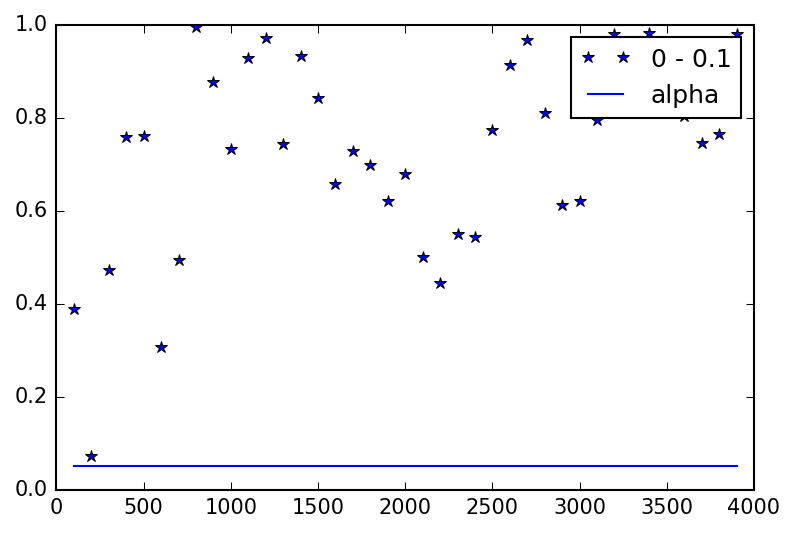

In [5]:
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

i = 1
x = []
y = {}
y[i] = []
alpha = 0.05
        
for threshold in range(100, 4000, 100):
    x.append(threshold)
    
    analysis_data = {}
    analysis_data[0] = data[1][:threshold]
    analysis_data[1] = data[3][:threshold]
    
    t = Ttest(fake_run_id, y_key, alpha=alpha).start(analysis_data, {})
    y[i].append(t["pvalue"])

    
fig,ax = plt.subplots()
ax.plot(x,y[i],'b*',label='0 - 0.'+str(i))
ax.plot(x,[0.05]*len(x), label='alpha')

plt.legend()
plt.show()